# **Predicting the Multiple Deprivation Degrees from VHR Satelite Images.**

## Intro

This code is developed by **Eqi Luo** for his MSc Research ***'Mapping and Predicting the Multiple Deprivation Degrees at Intra-city Level.'***  

In this analysis, we aim to train a CNN-based regression model, which can predict the deprivation index ranging between 0 to 1 based on the satellite image i.e., instead of following the traditional binary classification to distinguish slum/non-slum, the outcome would be a quantitative estimation of multiple deprivation level. 

The inputs used in this model are twofold: 
1) the SPOT satellite image of Nairobi city, 2017. Resolution = 1.5m, with 4 bands (RGB + near-infrared)

2) the multiple deprivation indices(MDI) of urban built-up Nairobi at 100m grid scale, generated using Principle Component Analysis (PCA). The results have been validated/cross-discussed with previous studies and local knowledge, which should be regarded as eligible datasets for this experimental research of using RS data to predict deprivation level. 

Note that the MDI is a portfolio, which consists a final comprehensive deprivation scores, and 4 individual deprivation indices of the sub-domains of multiple deprivation. A summary of the 'label' were provided:
- PC1: Accessibility to facilities, income level and maternal health support.
- **PC2: Dense urbanization, absence of green space and waste management.** (the one that manifests the most in RS images)
- PC3: Air and water contamination.
- PC4: Transport infrastructure. 

## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os
import pandas as pd
import glob
import re
import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras import backend as K



ModuleNotFoundError: No module named 'keras'

## 1. Data preparation 

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

### 1.1 Loading, structuring the data

In [4]:
a=6

In [2]:
# Define working path 
root = os.getcwd()
image_path = os.path.join(root, "Image tiles")
label_path = os.path.join(root, "Reference label")


In [3]:
# Create a list of all the filenames of images
tile_list = [x for x in os.listdir(image_path) if x.endswith(".TIF")]

# Sort the list naturally based on the number in the filename.
tile_list = natsorted(tile_list)


In [4]:
# Loop over and read all the images as numpy array, then stack them together 
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=64, win_ysize=64) #here we only read 64*64 chunk of the original 65*65 image
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    stack.append(data)

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(7000, 64, 64, 4)


In [5]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

uint32


In [6]:
# Convert the datatype from interger to float32! 
stack = stack.astype('float32')
print(stack.dtype)

float32


**The standardization of pixel values was dropped**, given the fact that: 
- batch normalization was applied throughout the CNN model, ensuring the input for next layers always staying in a relatively same range to reduce internal covariates shift and accelerate the training. Therefore, the normalization of input was not really necessary; 
- the standardization was applied on the subsets of original images, instead of the entire dataset. So later when apply the trained model to the whole nairobi, the normalized values might be shifted as the subset&original data share the different mean, variation.  

In [7]:
#def standardize(image_data):
        #image_data -= np.mean(image_data, axis=0)
        #image_data /= np.std(image_data, axis=0)
        #return image_data

#stack = standardize(stack)
print(stack.shape)

(7000, 64, 64, 4)


In [8]:
# Load the deprivation indices dataset and check it out
labels = pd.read_csv(label_path+os.path.sep+'Deprivation_index.csv')
print(labels)

        ID   PC1_N_1   PC2_N_1   PC3_N_1   PC4_N_1  Final_idx  gridcode
0        0  0.424625  0.064369  0.718921  0.479331   0.423162     45546
1        1  0.421739  0.070148  0.749208  0.444306   0.416208     45552
2        2  0.427357  0.045825  0.705986  0.414481   0.369917     45517
3        3  0.402702  0.065997  0.749541  0.495730   0.435842     45524
4        4  0.358065  0.068114  0.474223  0.556850   0.349568     45492
...    ...       ...       ...       ...       ...        ...       ...
6995  6995  0.389289  0.096484  0.612534  0.497073   0.397501        20
6996  6996  0.350845  0.064575  0.558015  0.496439   0.340316        30
6997  6997  0.403495  0.142613  0.587754  0.468073   0.405277        11
6998  6998  0.369689  0.101518  0.555754  0.490405   0.366597        13
6999  6999  0.352305  0.092205  0.546746  0.490198   0.349815        16

[7000 rows x 7 columns]


**As a starting point, we first extract the PC2 values (Morphological deprivation indices) to train this model, because:** 
- the information on PC2 were derived from 4 main variables: population density, building density, Maximum NDVI and density of illegal dumpsite. It is the indices that most related to urban morphology, which could be partially captured by the RS images using deep learning. 
- most of the highly deprived pixels in PC2 are overlapping with the slum regions (which has been successfully detected by CNN in previous studies) 

In [9]:
# Extract the values of PC2 and covert it to a 1-d array 
PC2_column = labels.loc[:,'PC2_N_1']
PC2 = PC2_column.values

# Now we need to reshape the 1-d array to a 2-d array 
PC2 = PC2.reshape(7000,-1)

# Check the shape and datatype of reference data
print(PC2.shape)
print(PC2.dtype)
print(PC2)

(7000, 1)
float64
[[0.06436907]
 [0.07014808]
 [0.04582458]
 ...
 [0.14261348]
 [0.10151825]
 [0.09220457]]


In [10]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(PC2.shape)

(7000, 64, 64, 4)
(7000, 1)


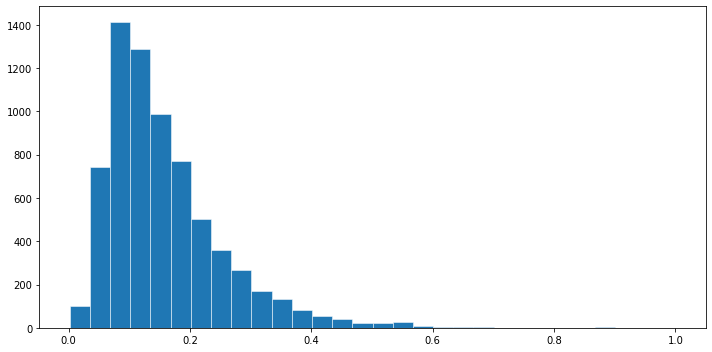

In [11]:
# print the distribution of target variables (y)

fig, axs = plt.subplots(1, 1,figsize =(10, 5), tight_layout = True)
  
axs.hist(PC2, bins = 30, edgecolor='white', linewidth=0.5)
  
# Show plot
plt.show()

### 1.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

the proportion of training+validation and test follows the rule of thumb, 70% vs 30%.

In [12]:
# Split the inputs. Note that variable 'stack' is the X (imagery features), and variable 'PC2' is the Y (labels).  

x_train, x_val, y_train, y_val = train_test_split(
    stack, PC2, test_size = 0.3, random_state = 27) # specify the random state to ensure replicable output across multiple function calls.

# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(4900, 64, 64, 4)
(4900, 1)
(2100, 64, 64, 4)
(2100, 1)


## 2. Deep CNN-based Regression Model 

In this part, we build a VGG-like model to predict the deprivation degree.

The CNN model has 4 convolution blocks and 3 fully connected layers. The details were presented below

### 2.1 Model Architecture Definition

In [13]:
# Model definition 

input_shape = (64, 64, 4)

# We build a VGG-like regression model to predict the deprivation degree 

def EqiModel():
    model = Sequential()
    
    # block 1 
    model.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name = 'block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name = 'block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block1_pool')) #block1_pool
    
    # block 2 
    model.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name = 'block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name = 'block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block2_pool')) #block2_pool
    
    
    # block 3 
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name = 'block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name = 'block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block3_pool')) #block3_pool
    
    # block 4 
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv1')) #block4_conv1
    model.add(BatchNormalization(axis=-1, name = 'block4_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv2')) #block4_conv2
    model.add(BatchNormalization(axis=-1, name = 'block4_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv3')) #block4_conv3
    model.add(BatchNormalization(axis=-1, name = 'block4_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block4_pool')) #block4_pool

    
    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    model.add(Dense(512, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.25, name = 'fc1_drop1')) 
    #the dropout layers were discarded after hyper-parameter tuning!
    
    # FC2
    model.add(Dense(256, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5, name = 'fc2_drop1'))
    
    # Regreesion layer 
    model.add(Dense(1, activation = 'sigmoid', name = 'regression'))
    return model

    
    
model = EqiModel()
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        2368      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0

### 2.2 Setting up the model

In [15]:
# Adam was applied as the optimizer for this model, with learning rate at 0.0001 

opt = Adam(lr=1e-3)

In [16]:
# Specify the R2 calculation formula to use as an assessment metirc. 

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [17]:
# Compilation of the model, loss function = MAE, metircs = MAPE 

model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 

In [18]:
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 

checkpoint_filepath = '/data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/model/516_mae_best_performed_model.hdf5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

In [19]:
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.

#Reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=20, verbose=1, mode='auto', cooldown=0, min_lr=0)

### 2.3 Training the model

Note that the batch size was set to 128 after hyper-parameter tuning. 

Within the 'training+validation' datasets, 70% were used to train the model and 30% were used for validation. 


In [20]:
# train the model 

hist = model.fit(x_train, y_train, batch_size = 32, epochs = 80, verbose=1, validation_data = (x_val,y_val),callbacks = [checkpoint])

Epoch 1/80
154/154 [==============================] - 40s 185ms/step - loss: 0.1116 - mean_absolute_error: 0.1116 - root_mean_squared_error: 0.1862 - coeff_determination: -4.3532 - val_loss: 0.2422 - val_mean_absolute_error: 0.2422 - val_root_mean_squared_error: 0.3304 - val_coeff_determination: -11.4752

Epoch 00001: val_mean_absolute_error improved from inf to 0.24220, saving model to /data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/model/516_mae_best_performed_model.hdf5
Epoch 2/80
154/154 [==============================] - 24s 154ms/step - loss: 0.0643 - mean_absolute_error: 0.0643 - root_mean_squared_error: 0.0924 - coeff_determination: 0.0258 - val_loss: 0.2404 - val_mean_absolute_error: 0.2404 - val_root_mean_squared_error: 0.2560 - val_coeff_determination: -6.8388

Epoch 00002: val_mean_absolute_error improved from 0.24220 to 0.24040, saving model to /data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/model/516_mae_best_performed_model.hdf5


### 2.4 Visualizing the training history  
In this part, we plot the loss curve and metric curve

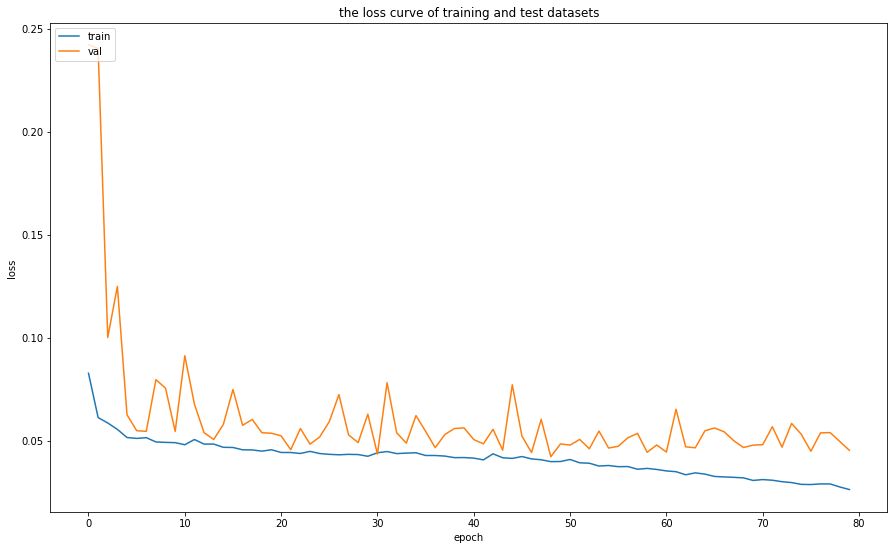

In [21]:
# plot model training history

fig = plt.subplots(figsize=(15, 9))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("the loss curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")

plt.savefig('/data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/graphs/training_curve/mae_loss.png', dpi = 300)

plt.show()

#plt.savefig('loss_curve_1.png', dpi = 300)



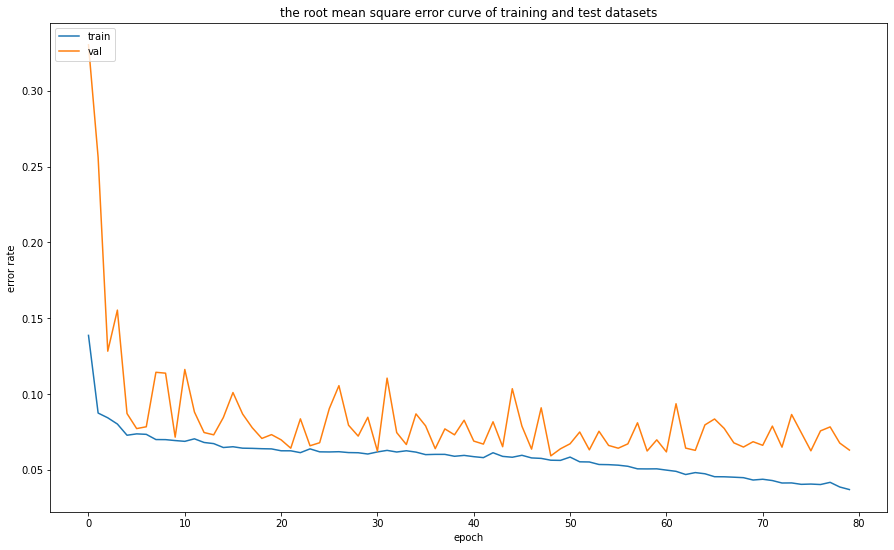

In [22]:

fig = plt.subplots(figsize=(15, 9))
plt.plot(hist.history["root_mean_squared_error"])
plt.plot(hist.history["val_root_mean_squared_error"])
plt.title("the root mean square error curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("error rate")
plt.xlabel("epoch")

plt.savefig('/data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/graphs/training_curve/mae_rmse.png', dpi = 300)

plt.show()

#plt.savefig('mse_curve_1.png', dpi = 300)

## 3. Assessing the model performance on test datasets

### 3.1 Save and configure the model with best performance 

In this step, we will configure the model by reloading the weights of best performance through training, and apply it on both the training and validation datasets. The scatter plots will be created to evaluate the model prediction by comparing training and validation datasets, to see if there are over-/under-estimation or over-fitting etc. 

In [23]:
best_model = EqiModel()

best_model.load_weights(checkpoint_filepath)

### 3.2 Applying the model on validation datasets 

In [24]:
# run the model on the train and test datasets 

y_pred_val = best_model.predict(x_val) 
y_pred_train = best_model.predict(x_train)


In [25]:
# calculate the R2 Score and RMSE

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

R2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
mae_train = mean_absolute_error(y_train, y_pred_train)

print("the R2 of training dataset is: %0.4f" %R2_train)
print("the RMSE of training dataset is: %0.4f" %rmse_train)
print("the MAE of training dataset is: %0.4f" %mae_train)


R2_val = r2_score(y_val,y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val,squared=False) 
mae_val = mean_absolute_error(y_val, y_pred_val) 

print("the R2 of validation dataset is: %0.4f" %R2_val)
print("the RMSE of validation dataset is: %0.4f" %rmse_val)
print("the MAE of validation dataset is: %0.4f" %mae_val)

the R2 of training dataset is: 0.7116
the RMSE of training dataset is: 0.0517
the MAE of training dataset is: 0.0367
the R2 of validation dataset is: 0.6558
the RMSE of validation dataset is: 0.0591
the MAE of validation dataset is: 0.0423


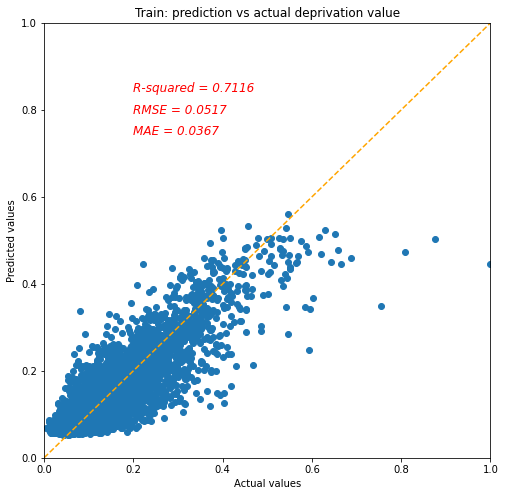

In [26]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_train, y_pred_train)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Train: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig('/data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/graphs/scatter_plot/mae_train.png', dpi = 300)

plt.show()

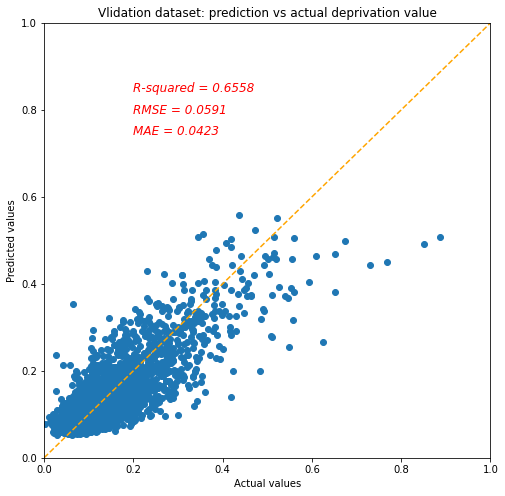

In [27]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_val, y_pred_val)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Vlidation dataset: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig('/data/private/Nairobi_MSc/CNN_Model/PC2 Prediction/results_recording/graphs/scatter_plot/mae_val.png', dpi = 300)

plt.show()